In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

In [2]:
from recalibration import *
from utilities import *
from model import *
from dataloader import *
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
import random
from tueplots import bundles
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-05-25 17:08:06.049080: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [4]:
train_list = [[2361, 7719, 9019, 2335, 7951]]
cal_list = [[5746, 8565, 8156, 8386, 9160]]
test_list = [[4373, 7901, 3456, 3538, 2818]]

In [5]:
dict_bs_lr = {'air': (2048, 0.0001), 'refrigerator': (1024, 0.0001), 'furnace': (
    2048, 0.00001), 'dishwasher': (4096, 0.0001), 'clotheswasher': (2048, 0.0001)}
appliance = 'furnace'

In [6]:
train_houses = train_list[0]
test_houses = test_list[0]
cal_houses = cal_list[0]
train = data_aggregated[data_aggregated["dataid"].isin(train_houses)]
test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]
cal = data_aggregated[data_aggregated["dataid"].isin(cal_houses)]

In [7]:
n = 99
x_train, y_train = dataloader(
    appliance, train, "2018-03-01 00:00:00-06", "2018-03-15 23:59:00-06", n)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)
x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
y_train = jnp.array(y_train)

In [8]:
model = seq2point()
params = model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False,
                     batch_size=dict_bs_lr[f'{appliance}'][0], learning_rate=dict_bs_lr[f'{appliance}'][1], epochs=30)

Training Progress:   0%|          | 0/1110 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress: 100%|██████████| 1110/1110 [00:10<00:00, 105.03epoch/s]


In [9]:
x_test, y_test = dataloader(
    appliance, test, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_test = scaler_x.transform(x_test)
x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
y_test = jnp.array(y_test)

In [10]:
x_cal, y_cal = dataloader(
    appliance, cal, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_cal = scaler_x.transform(x_cal)
x_cal = jnp.array(x_cal).reshape(x_cal.shape[0], n, 1)
y_cal = jnp.array(y_cal)

In [11]:
y_hat_test = model.apply(params, x_test, True, rngs={
                         "dropout": jax.random.PRNGKey(0)})
test_mean = scaler_y.inverse_transform(y_hat_test)
print(
    f"RMSE : {rmse(y_test, test_mean):.4f}, MAE : {mae(y_test, test_mean):.4f}")

RMSE : 443.2474, MAE : 164.4928


In [12]:
y_hat_train = model.apply(params, x_train, True, rngs={
                          "dropout": jax.random.PRNGKey(0)})
train_mean = scaler_y.inverse_transform(y_hat_train)
print(
    f"RMSE : {rmse(y_train, train_mean):.4f}, MAE : {mae(y_train, train_mean):.4f}")

RMSE : 355.8849, MAE : 107.2401


In [13]:
y_hat_cal = model.apply(params, x_cal, True, rngs={
                        "dropout": jax.random.PRNGKey(0)})
cal_mean = scaler_y.inverse_transform(y_hat_cal)
print(f"RMSE : {rmse(y_cal, cal_mean):.4f}, MAE : {mae(y_cal, cal_mean):.4f}")

RMSE : 881.1959, MAE : 360.8031


## After Calibration

In [14]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

## Conformal Prediction

In [15]:
def find_coverage_calib(y, y_noisy, ci):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    q_hats = []
    coverage = np.zeros(len(ci))
    maes = []
    for i in range(len(ci)):
        if ci[i] == 0 or ci[i] == 1:
            coverage[i] = ci[i]
            q_hats.append(0)
            continue
        # E_i = []
        # for j in range(len(y)):
        #     # E_i.append(abs(y[j]-y_noisy[j] + keys[j]))
        #     E_i.append(abs(y[j]-y_noisy[j]))
        maes = abs(np.array(y).reshape(-1) - np.array(y_noisy).reshape(-1))
        # E_i = maes
        q_level = np.ceil((len(y)+1)*ci[i])/len(y)
        # print("q_level: ", q_level)
        q_hat = np.quantile(maes, q_level, method='higher')
        q_hats.append(q_hat)
        upper = y_noisy + q_hat
        lower = y_noisy - q_hat
        coverage[i] = np.sum((y >= lower) & (
            y <= upper)) / len(y)
    return coverage, q_hats, maes

In [16]:
# def find_coverage_calib(y, y_noisy, ci, keys):
#     alpha = 1 - ci                  # size = len(ci)
#     k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
#     q_hats = []
#     coverage = np.zeros(len(ci))
#     maes = []
#     for i in range(len(ci)):
#         if ci[i] == 0 or ci[i] == 1:
#             coverage[i] = ci[i]
#             q_hats.append(0)
#             continue
#         # E_i = []
#         # for j in range(len(y)):
#         #     # E_i.append(abs(y[j]-y_noisy[j] + keys[j]))
#         #     E_i.append(abs(y[j]-y_noisy[j]))
#         maes = abs(np.array(y).reshape(-1) - np.array(y_noisy).reshape(-1) + keys)
#         # E_i = maes
#         q_level = np.ceil((len(y)+1)*ci[i])/len(y)
#         # print("q_level: ", q_level)
#         q_hat = np.quantile(maes, q_level, method='higher')
#         q_hats.append(q_hat)
#         upper = y_noisy + q_hat
#         lower = y_noisy - q_hat
#         coverage[i] = np.sum((y >= lower) & (
#             y <= upper)) / len(y)
#     return coverage, q_hats, maes

In [17]:
def find_coverage_train_test(y, y_noisy, ci, q_hats):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    coverage = np.zeros(len(ci))
    for i in range(len(ci)):
        if ci[i] == 0 or ci[i] == 1:
            coverage[i] = ci[i]
            continue
        upper = y_noisy + q_hats[i]
        lower = y_noisy - q_hats[i]
        coverage[i] = np.sum((y >= lower) & (
            y <= upper)) / len(y)
        # check if 0 is in ci array and if so, set coverage to 0 at that index

    return coverage, q_hats

In [18]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

Calibration dataset

In [19]:
# keys = jax.random.normal(jax.random.PRNGKey(0), shape = (len(y_hat_cal),))*0.03
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
coverages_cal, q_hats, maes = find_coverage_calib(y_cal, y_hat_cal, ci)

In [20]:
coverages_cal

array([0.        , 0.10003085, 0.20003965, 0.30004847, 0.40001321,
       0.50004405, 0.60005289, 0.70003963, 0.80004847, 0.90005726,
       1.        ])

In [21]:
ace_fin_cal, ece_fin_cal = calib_errors(ci, coverages_cal)
print('Calibration:')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Final ace error is 0.00037447363138196077 and ece error is 3.404305739836007e-05


In [22]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
coverages_train, _ = find_coverage_train_test(
    y_train, y_hat_train, ci, q_hats)
coverages_train

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [23]:
coverages_train

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
q_hats

[0,
 7.188746,
 7.217069,
 8.202554,
 8.776577,
 11.878248,
 423.09302,
 428.0425,
 478.42865,
 659.7782,
 0]

In [25]:
ace_fin_train, ece_fin_train = calib_errors(ci, coverages_train)
print('Train:')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Final ace error is 4.5 and ece error is 0.4090909090909091


In [26]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
coverages_test, _ = find_coverage_train_test(
    y_test, y_hat_test, ci, q_hats)
coverages_test

array([0.        , 0.37823251, 0.41670781, 0.54299527, 0.54399973,
       0.64721906, 0.81211799, 0.81232232, 0.81634009, 0.91584808,
       1.        ])

In [27]:
ace_fin_test, ece_fin_test = calib_errors(ci, coverages_test)
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Final ace error is 1.3857828676700592 and ece error is 0.1259802606972781


In [28]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

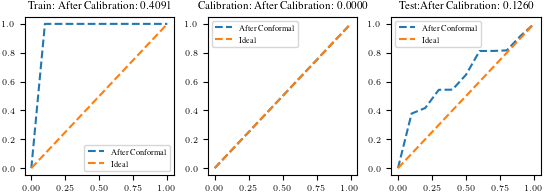

In [29]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (5.5, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, coverages_train, label='After Conformal', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train: After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, coverages_cal, label='After Conformal', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration: After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, coverages_test, label='After Conformal', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()